[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/azad-academy/denoising-diffusion-model/blob/main/diffusion_model_demo.ipynb)

## Learning Channel Distribution by Diffusion Models
 
This notebook file is a framework to learn channels by their conditional distributions: the distirubtions of the channel output for given channel inputs. To serve that, we edited a standard 1-dimensional U-Net to be conditional on the channel input. For the channel model, we used a correlated Rayleigh fading model.

In [1]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import torch
#import tqdm as notebook_tqdm
from tqdm import tqdm

import sys
sys.path.append('src/')

# Import modules from own libraries
from denoising_diffusion_pytorch_1d_cond import GaussianDiffusion1D, Unet1D, Trainer1D, Dataset1D
import channel_models

# Set the device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Choose channel model and diffusion model type

In [2]:
channel_model_str = 'corrRayleigh' #available options: AWGN, Rayleigh, SSPA

## Channel model settings

In [3]:
def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

class Channel_Config:
    def __init__(self, channel_model_str, blocklength, training_noise_std, device="cpu", f_dopp_norm=None):
        super().__init__()
        self.channel_model_str = channel_model_str
        self.blocklength = blocklength
        self.training_noise_std = training_noise_std
        self.device = device
        self.f_dopp_norm = f_dopp_norm
        self.cov = channel_models.Rayleigh_covariance_generator(n, f_dopp_norm,
                                                 dtype_cov=torch.cfloat) if f_dopp_norm is not None else None

    def channel_model_fn(self):
        channel_model_str = self.channel_model_str
        if channel_model_str == 'AWGN':
            channel_model = channel_models.ch_AWGN
        elif channel_model_str == 'Rayleigh':
            channel_model = channel_models.ch_Rayleigh_AWGN_n
        elif channel_model_str == 'SSPA':
            channel_model = channel_models.ch_SSPA
        elif channel_model_str == 'corrRayleigh':
            assert f_dopp_norm is not None, 'The normalized doppler frequency, f_dopp_norm, is not given.'
            cov = self.cov
            channel_model = partial(channel_models.ch_corr_Rayleigh_by_cov, Cov_h=cov)
        else:
            raise Exception("Unrecognized channel model. Possible channel models: AWGN, Rayleigh, SSPA.")
        self.channel_model = channel_model
        return channel_model

    def show_cov(self):
        fig, ax = plt.subplots(figsize=(3, 3))
        im = ax.imshow(self.cov.real, cmap='hot', )  # , interpolation='nearest')
        #ax.set_title(r'Covariance, $\bar{f}_D=' + str(self.f_dopp_norm) + '$')
        plt.colorbar(im, ax=ax, fraction=0.046)
        plt.savefig(f'figures/cov_fD={self.f_dopp_norm:.3f}.pdf', bbox_inches='tight')
        plt.show()


In [4]:
def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

In [5]:
def generate_training_seq(dataset_size, Config_ch, batch_size = 100):
    n = Config_ch.blocklength
    training_seq = torch.zeros(dataset_size, 2*2, n)
    idx = 0
    for i, batch in enumerate(torch.split(training_seq, batch_size)):
        bs = batch.shape[0]
        
        training_x = torch.randn(bs, n, dtype=torch.cfloat, device=Config_ch.device)
        channel_model = Config_ch.channel_model_fn()
        training_y = channel_model(training_x, Config_ch.training_noise_std, Config_ch.device)
        training_x = torch.transpose(torch.view_as_real(training_x), 1, 2)
        training_y = torch.transpose(torch.view_as_real(training_y), 1, 2)
        training_seq[idx:idx+bs, :, :] = torch.cat((training_y, training_x), dim=1)
        idx += bs
    return training_seq

In [6]:
# Channel Model
n = 128  # Block length
f_dopp_norm = 0.01

TRAINING_SNR = 15 # decibel
noise_std = SNR_to_noise(TRAINING_SNR)
Config_ch = Channel_Config(channel_model_str, n, noise_std, device=device, f_dopp_norm=f_dopp_norm)

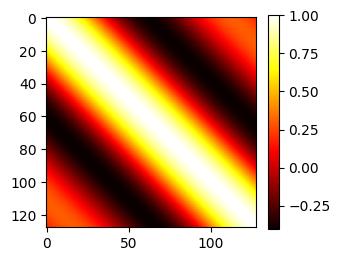

In [7]:
Config_ch.show_cov()

## Deep Learning Settings - model parameters, training and testing hyperparameters, etc.

In [8]:
# Diffusion Model 

model = Unet1D(
    dim = 24, 
    dim_mults = (1, 2, 4, 8),
    out_dim = 2, # Due to the assumption of the complex channel
    channels = 2 * 2, # Because of feeding the condition sequence having the same size   
    channels_out = 2 # Due to the assumption of the complex channel
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = n, # size of the input sequence.
    timesteps = 100,
    objective = 'pred_v'
)

In [9]:
training_seq = generate_training_seq(10 ** 3, Config_ch)
dataset = Dataset1D(training_seq) 

In [10]:
trainer = Trainer1D(
    diffusion,
    dataset = dataset,
    train_batch_size = 1000,
    train_lr = 1e-5,
    train_num_steps = 70000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
)

trainer.load(milestone=50)
#trainer.train()

loading from version 1.9.5


In [11]:
model

Unet1D(
  (init_conv): Conv1d(4, 24, kernel_size=(7,), stride=(1,), padding=(3,))
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=24, out_features=96, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=96, out_features=96, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=96, out_features=48, bias=True)
        )
        (block1): Block(
          (proj): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
          (norm): GroupNorm(8, 24, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
          (norm): GroupNorm(8, 24, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (1): ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
         

In [12]:
total_params_gen = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('# of parameters (diffusion model): ' + str(total_params_gen))

# of parameters (diffusion model): 2338418


loading from version 1.9.5
The trainer is loaded with the model of the 50-th milestone.


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

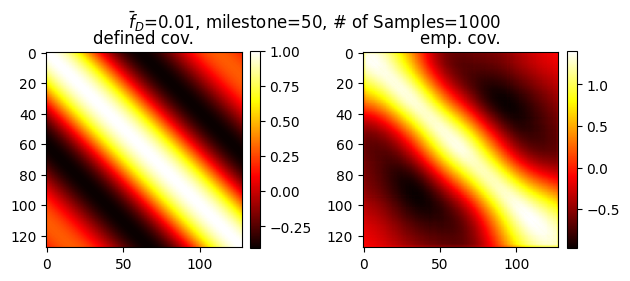

In [17]:
def compare_empirical_cov(trainer, Config_ch, num_samples = 10 **3, bs=100, milestone=None):
    # y = Hx = h, when H = diag(h) and x = (1,1,1,...,1,1)^T. 
    ## For such channel input, generative network can generate the channel state information h.

    ## Load the model
    if milestone is not None:
        trainer.load(milestone=milestone)
        print(f"The trainer is loaded with the model of the {milestone}-th milestone.")
    
    ## Sample the channel coefficients by using the identity channel input. 
    
    condition_ones = torch.ones([bs, n], dtype=torch.cfloat, device=device)
    condition_ones = torch.transpose(torch.view_as_real(condition_ones), 1,2).contiguous()
    h_gen = torch.ones([num_samples // bs * bs, n], dtype=torch.cfloat)
    for i in range(num_samples//bs):
        generated_h = diffusion.sample(batch_size = bs, condition=condition_ones)
        generated_h_t = torch.transpose(generated_h, 1,2)
        generated_h_t = generated_h_t.contiguous() # After taking transpose, it's necessary. 
        
        h_gen[i*bs:(i+1)*bs,:] = torch.view_as_complex(generated_h_t)
    
    cov_emp = torch.cov(h_gen.T).detach().cpu().numpy()
    idx = np.arange(n)    
    cov_emp[idx, idx] -= 2*noise_std ** 2
    
    fig_cov_comparison, [ax1, ax2] = plt.subplots(1,2)
    im1 = ax1.imshow(Config_ch.cov.real, cmap='hot') # , interpolation='nearest')
    ax1.set_title('defined cov.')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    im2 = ax2.imshow(cov_emp.real, cmap='hot')#, interpolation='nearest')
    ax2.set_title('emp. cov.')
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    fig_cov_comparison.suptitle(
        r'$\bar{f}_{D}$'+f'={Config_ch.f_dopp_norm}, milestone={milestone}, # of Samples={num_samples}', y=0.75)
    fig_cov_comparison.tight_layout()
    plt.savefig(f'figures/emp_cov_DM_vcos_fD_{f_dopp_norm:.3f}_ns{num_samples}_ms{milestone}.pdf')
    plt.show()
    return h_gen

generated_h = compare_empirical_cov(trainer, Config_ch, num_samples = 10 **5, milestone=50)


In [14]:
torch.save(generated_h, 'var/generated_h_vcos_ms{milestone}.pt')

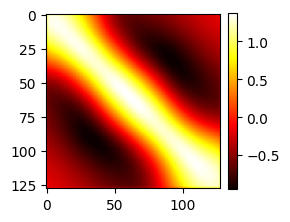

In [16]:
cov_emp = torch.cov(generated_h.T).detach().cpu().numpy()
idx = np.arange(n)    
cov_emp[idx, idx] -= 2*noise_std ** 2

fig_cov_comparison, ax2 = plt.subplots(figsize=(3,3))
im2 = ax2.imshow(cov_emp.real, cmap='hot')#, interpolation='nearest')
#ax2.set_title('emp. cov.')
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
#fig_cov_comparison.suptitle(
#    r'$\bar{f}_{D}$'+f'={Config_ch.f_dopp_norm}, milestone={milestone}, # of Samples={num_samples}', y=0.75)
fig_cov_comparison.tight_layout()
plt.savefig(f'figures/emp_cov_DM_vcos_fD_{f_dopp_norm:.3f}_ns{1000}_ms{50}.pdf', bbox_inches='tight')
plt.show()

In [18]:
num_samples = 10**5
bs = 100

# Compute a matrix A such that A*A^H = Cov.
        
# Compute the Cholesky decomposition.
A = torch.linalg.cholesky(Config_ch.cov, upper=False)  # torch.cholesky(Cov, upper=False)
# print(torch.mm(A, A.conj().T))
# print(Cov_h)
A = A[None, :, :].repeat(bs, 1, 1).to(device)
h_t = torch.zeros(num_samples//bs * bs, 2*n)

for i in range(num_samples // bs):
    # generate normally distributed matrices
    h = torch.normal(mean=0., std=1., size=(bs, n), device=device, dtype=torch.cfloat)
    h = h[:, :, None]
    # Correlated channel matrices h = Ah,  A[n,n] h[n, 1]
    h = torch.bmm(A, h)
    h = h.view(bs, n)
    h_t[bs*i:bs*(i+1),:] = torch.view_as_real(h).view(-1,2*n).contiguous()
    

In [14]:
def _sort_rows_tf(matrix, num_rows):
  """Sort matrix rows by the last column.

  Args:
      matrix: a matrix of values (row,col).
      num_rows: (int) number of sorted rows to return from the matrix.

  Returns:
      Tensor (num_rows, col) of the sorted matrix top K rows.
  """
  tmatrix = tf.transpose(a=matrix, perm=[1, 0])
  sorted_tmatrix = tf.nn.top_k(tmatrix, num_rows)[0]
  return tf.transpose(a=sorted_tmatrix, perm=[1, 0])

def _sliced_wasserstein_tf(a, b, random_sampling_count, random_projection_dim):
  """Compute the approximate sliced Wasserstein distance.

  Args:
      a: (matrix) Distribution "a" of samples (row, col).
      b: (matrix) Distribution "b" of samples (row, col).
      random_sampling_count: (int) Number of random projections to average.
      random_projection_dim: (int) Dimension of the random projection space.

  Returns:
      Float containing the approximate distance between "a" and "b".
  """
  s = tf.shape(input=a)
  means = []
  for _ in range(random_sampling_count):
    # Random projection matrix.
    proj = tf.random.normal([tf.shape(input=a)[1], random_projection_dim])
    proj *= tf.math.rsqrt(
        tf.reduce_sum(input_tensor=tf.square(proj), axis=0, keepdims=True))
    # Project both distributions and sort them.
    proj_a = tf.matmul(a, proj)
    proj_b = tf.matmul(b, proj)
    proj_a = _sort_rows(proj_a, s[0])
    proj_b = _sort_rows(proj_b, s[0])
    # Pairwise Wasserstein distance.
    wdist = tf.reduce_mean(input_tensor=tf.abs(proj_a - proj_b))
    means.append(wdist)
  return tf.reduce_mean(input_tensor=means)



def _sort_rows(matrix, num_rows):
  """Sort matrix rows by the last column.

  Args:
      matrix: a matrix of values (row,col).
      num_rows: (int) number of sorted rows to return from the matrix.

  Returns:
      Tensor (num_rows, col) of the sorted matrix top K rows.
  """
  tmatrix = torch.transpose(matrix, 1, 0) 
  sorted_matrix = torch.topk(tmatrix, k=num_rows)[0] #tf.nn.top_k(tmatrix, num_rows)[0]
  return torch.transpose(sorted_matrix, 1, 0) 

def _sliced_wasserstein(a, b, random_sampling_count, random_projection_dim=1):
  """Compute the approximate sliced Wasserstein distance.

  Args:
      a: (matrix) Distribution "a" of samples (row, col).
      b: (matrix) Distribution "b" of samples (row, col).
      random_sampling_count: (int) Number of random projections to average.
      random_projection_dim: (int) Dimension of the random projection space.

  Returns:
      Float containing the approximate distance between "a" and "b".
  """
  s = a.shape #tf.shape(input=a)
  means = []
  for _ in range(random_sampling_count):
    # Random projection matrix.
    proj = torch.randn(s[1], random_projection_dim) 
    proj *= (torch.sum(proj ** 2, dim=0)) ** (-0.5) # normalizing the projection 
    # Project both distributions and sort them.
    proj_a = torch.matmul(a, proj) 
    proj_b = torch.matmul(b, proj) 
    proj_a = _sort_rows(proj_a, s[0])
    proj_b = _sort_rows(proj_b, s[0])
    # Pairwise Wasserstein distance.
    wdist = torch.mean( torch.abs(proj_a - proj_b) ) 
    means.append(wdist)
  return np.mean(means) 


In [28]:
generated_h_t = torch.view_as_real(generated_h).view(-1,2*n)
wasserstein_distance = _sliced_wasserstein(generated_h_t, h_t, 128)
print(wasserstein_distance)

0.24970737


In [31]:
torch.save(generated_h_t, 'samples/DM_vcos_generated_h.pt')

In [26]:
h_t.shape

torch.Size([100000, 256])